**УСПЕШНОСТЬ СТАРТАПОВ (1980-2018 гг.)**

**Цель проекта:**
1. Разработать модель машинного обучения для предсказания продолжения деятельности
стартапа.
2. Провести разведочный анализ и сформировать рекомендации будущим
создателям стартапов (какие факторы влияют на успешность стартапа).

**Исходные данные**

Заказчик предоставил данные в 2 файлах: тренировочный набор (53 тыс. записей) и тестовый набор (13 тыс. записей). Тренировочный набор включает целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Хронологичесие рамки - '1970-01-01' по '2018-01-01'. Дата выгрузки - '2018-01-01'

name -              Название стартапа  
category_list -     Список категорий, к которым относится стартап  
funding_total_usd - Общая сумма финансирования в USD  
status -            Статус стартапа (закрыт или действующий)  
country_code -      Код страны  
state_code -        Код штата  
region -            Регион  
city -              Город  
funding_rounds -    Количество раундов финансирования  
founded_at -        Дата основания  
first_funding_at -  Дата первого раунда финансирования  
last_funding_at -   Дата последнего раунда финансирования  
closed_at -         Дата закрытия стартапа (если применимо)  
lifetime -          Время существования стартапа в днях  

**ПЛАН исследования**

Шаг 1. Загрузка файлов с данными  
Шаг 2. Предобработка данных  
  2.1. Наименование столбцов  
  2.2. Пропуски  
  2.3. Типы данных  
  2.4. Дубликаты  
  2.5. Добавление новых столбцов  
Шаг 3. Исследовательский анализ данных  
Шаг 4. Подготовка данных  
Шаг 5. Выбор и обучение модели  
Шаг 6. Итоговая оценка качества предсказания лучшей модели  
Шаг 7. Анализ важности признаков  
Шаг 8. Отчёт по исследованию  

In [8]:
pip install phik==0.10.0 -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install optuna-integration

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pycountry -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [238]:
#импорт необходимых библиотек
import pandas as pd
import optuna
import time
import phik
import shap

import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn import model_selection, metrics
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from phik.report import plot_correlation_matrix
from phik import report
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from optuna import distributions
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

In [17]:
# задаём параметр random state
RANDOM_STATE = 42  

# задаем параметр разделения на тренировочныую и тестовую выборки
TEST_SIZE = 0.25  

<div class="alert alert-block alert-info">
Шаг 1. Загрузка данных
</div>

In [241]:
# задаём имена датасетам
data_train = pd.read_csv('C:/Users/pegof/Jupiter/kaggle_startups_train_28062024.csv')
data_test = pd.read_csv('C:/Users/pegof/Jupiter/kaggle_startups_test_28062024.csv')

In [243]:
# ознакомимся с data_train
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [21]:
data_train.sample(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
46414,Vesocclude Medical,Biotechnology,1515615.0,operating,USA,NC,Raleigh,Raleigh,1,2005-01-01,2011-10-25,2011-10-25,NaN
2383,SK&K Enterprises,Real Estate,NaN,operating,USA,TX,Houston,Galveston,1,2005-02-25,2015-07-05,2015-07-05,NaN
12691,gloStream,Health Care,19184620.0,operating,USA,MI,Detroit,Bloomfield Hills,5,2005-01-01,2009-05-28,2013-04-02,NaN
14295,What’s On Foodie,Classifieds|Events|Hospitality|Journalism|News...,20000.0,operating,GBR,NaN,NaN,NaN,1,2010-08-01,2011-07-01,2011-07-01,NaN
38822,Picwell,Internet,4018436.0,operating,USA,PA,Philadelphia,Philadelphia,1,2012-01-01,2015-07-01,2015-07-01,NaN
19135,Scholastica,Online Scheduling|Publishing|Web Hosting,510000.0,operating,USA,IL,Chicago,Chicago,1,2012-06-09,2014-05-07,2014-05-07,NaN
9630,Enprise Solutions,Software,1000000.0,operating,NZL,E7,NZL - Other,Avondale,1,2002-01-01,2006-02-16,2006-02-16,NaN
51538,Worksystems,Location Based Services|Nonprofits,8500000.0,operating,USA,OR,"Portland, Oregon",Portland,1,2012-12-14,2014-10-16,2014-10-16,NaN
49268,Joopp,Advertising|App Marketing|Facebook Application...,20323.0,operating,NLD,11,The Hague,The Hague,1,2013-01-01,2013-10-13,2013-10-13,NaN
17990,Echodyne,Consumer Electronics,15000000.0,operating,USA,KS,KS - Other,Wa Keeney,1,2014-01-11,2014-12-19,2014-12-19,NaN


In [22]:
data_train.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


In [168]:
# ознакомимся с data_test
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [170]:
data_test.sample(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
6925,HectoPlant,Energy,NaN,USA,TN,TN - Other,Leoma,1,2015-03-24,2015-03-24,1023
5761,Risk Ident,Fraud Detection,"2,300,000.00",DEU,4,Hamburg,Hamburg,2,2012-06-01,2013-03-01,2040
11668,Auditude,Advertising|Monetization|Video,"30,426,151.00",USA,CA,SF Bay Area,Palo Alto,4,2007-12-05,2011-01-24,6940
11263,TritonWear,Sports|Technology|Wearables,"1,000,000.00",CAN,ON,Toronto,Kitchener,1,2015-01-15,2015-01-15,1553
10252,TrelliSoft,Computers|Software|Storage,NaN,USA,IL,Chicago,Glen Ellyn,1,2002-03-11,2002-03-11,6697
6100,Cerevo,Hardware + Software|Mobile|Photo Sharing|Wireless,"44,525.00",JPN,40,Tokyo,Tokyo,2,2009-01-15,2011-02-18,3553
6979,Stefan's Head,E-Commerce|Fashion|Mobile Commerce,"110,000.00",NaN,NaN,NaN,NaN,1,2015-10-01,2015-10-01,1037
8107,HCI,Shipping|Software,NaN,USA,FL,Tampa,Tampa,1,2013-11-14,2013-11-14,3653
10851,Lekan.com,Video,NaN,CHN,22,Beijing,Beijing,1,2011-06-01,2011-06-01,4383
8587,Lehigh Technologies,Advanced Materials|Clean Technology|Specialty ...,"88,000,000.00",USA,GA,Atlanta,Tucker,6,2007-01-30,2014-09-03,5479


ВЫВОД  

Выведенные рандомные строки для обоих датасетов позволяют считать, что данные загружены верно и значения корректно распределены по столбцам. 
Cтолбцы с данными корректно протипизированы. Есть исключение - 'closed_at' в data_train. Далее, данный момент будет  исправлен. Отметим, что столбцы с неверными десятичными разделителями не наблюдаются. агах.

Датафрейм data_train включает 52 514 строк и 13 столбцов; есть пропуски.      
Датафрейм data_test  включает 13 125 строк и 12 столбцов; также есть пропуски.  

В data_train есть колонка 'closed_at' а в data_test она отсутствует. Но добавлена 'lifetime'. Указанные признаки тренировочных и тестовых данных будут приведены к единообразию в последующих шагах.  

Обратим внимание на неправдоподобные суммы инвестирования min и max. К ним потребуется вернуться на следующих этапах исследования для получения более коррекатных данных.

<div class="alert alert-block alert-info">
Шаг 2. Предобработка данных
</div>

In [30]:
# зафиксируем первоначальные габариты датасетов в переменных
data_train_shape = data_train.shape[0]
data_test_shape = data_test.shape[0]

<div class="alert alert-block alert-info">
Шаг 2.1. Наименования столбцов
</div>

Наименования колонок соответствуют общепринятым стандартам. Оставляем без изменений

<div class="alert alert-block alert-info">
Шаг 2.2. Пропуски
</div>

На предыдущем этапе были выявлены пропуски в категориальных и количественных данных.
Рассмотрим абсолютные и относительные показатели по пропускам для обоих датасетов.

In [35]:
# количество в тренировочных данных
data_train.isnull().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [36]:
# процент по столбцам в тренировочных данных
data_train.isnull().sum() * 100 / len(data_train)

name                  0.001904
category_list         4.693808
funding_total_usd    19.173204
status                0.000000
country_code         10.476807
state_code           12.877980
region               12.108691
city                 12.108691
funding_rounds        0.000000
founded_at            0.000000
first_funding_at      0.000000
last_funding_at       0.000000
closed_at            90.637139
dtype: float64

In [172]:
# количество в тестовых данных
data_test.isnull().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [38]:
# процент по столбцам в тестовых данных
data_test.isnull().sum() * 100 / len(data_test)

name                  0.000000
category_list         4.502857
funding_total_usd    19.641905
country_code         10.529524
state_code           12.914286
region               12.106667
city                 12.091429
funding_rounds        0.000000
first_funding_at      0.000000
last_funding_at       0.000000
lifetime              0.000000
dtype: float64

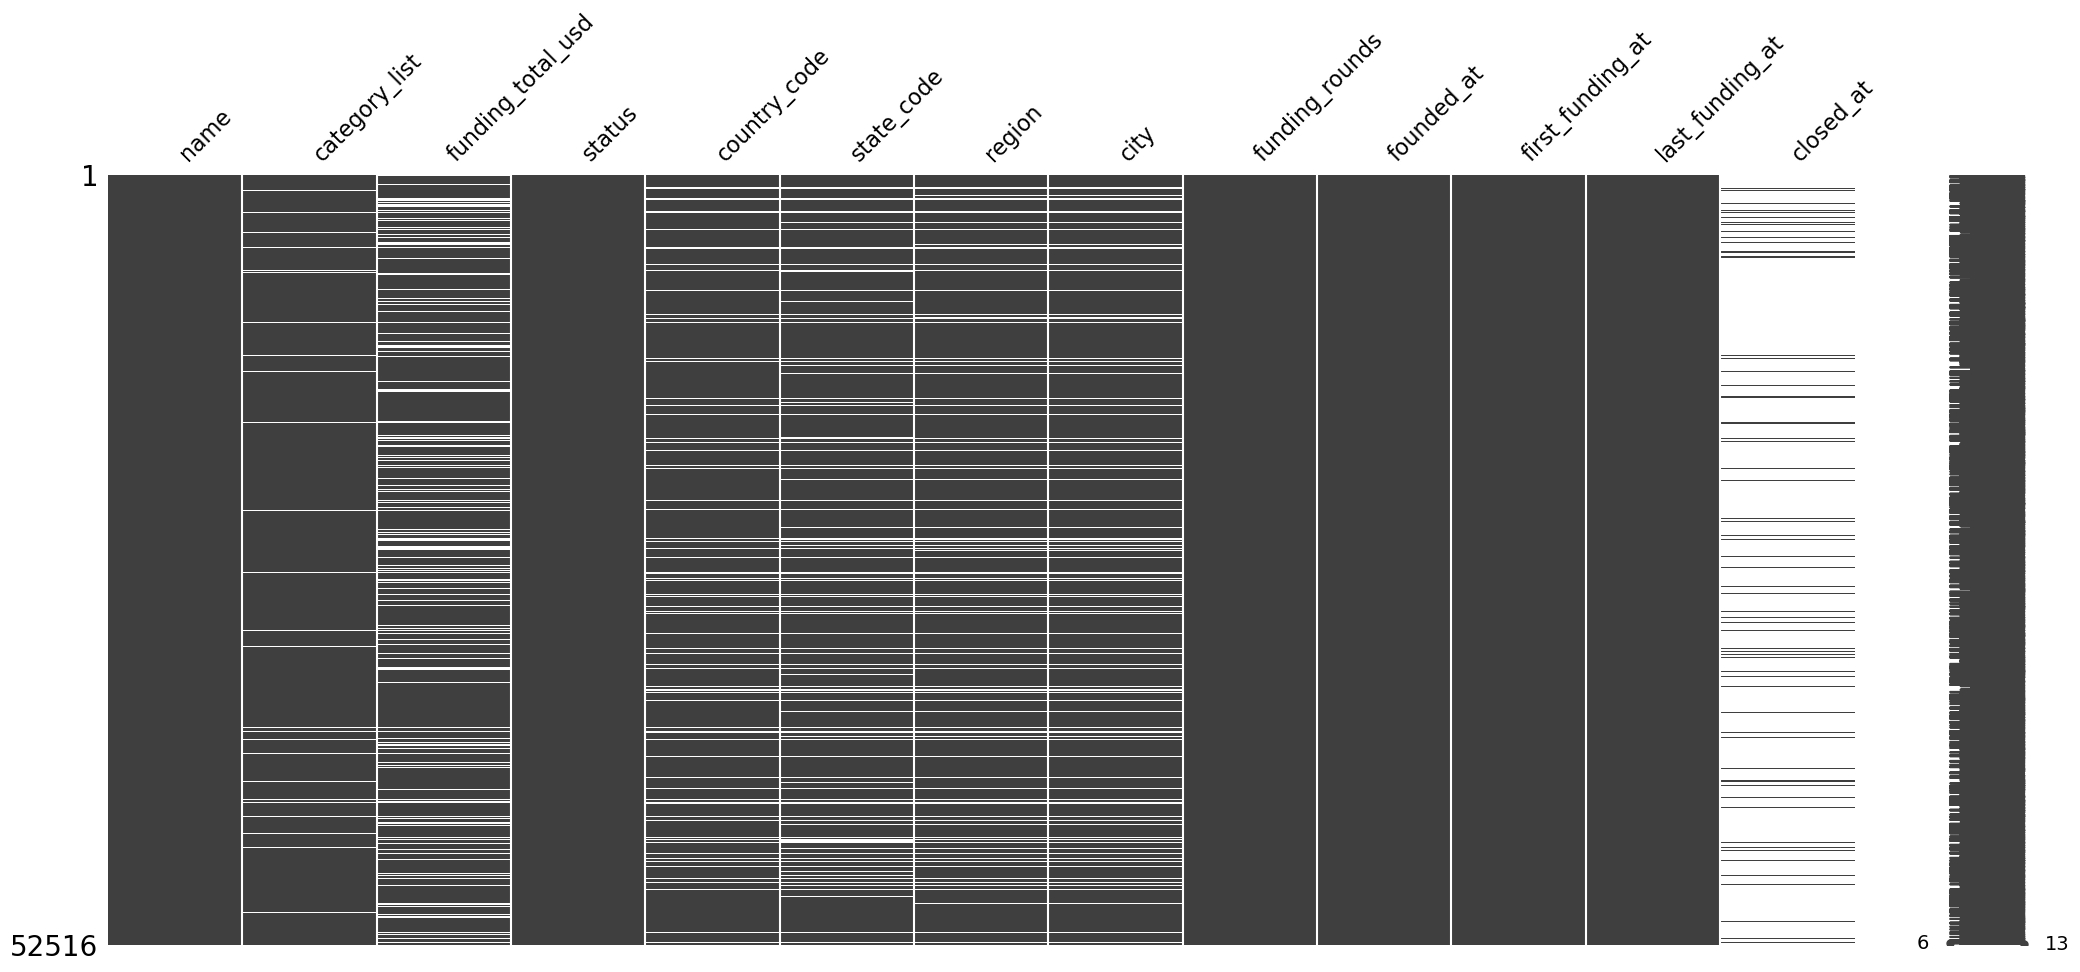

In [39]:
# визуализация пропусков для data_train
msno.matrix(data_train);

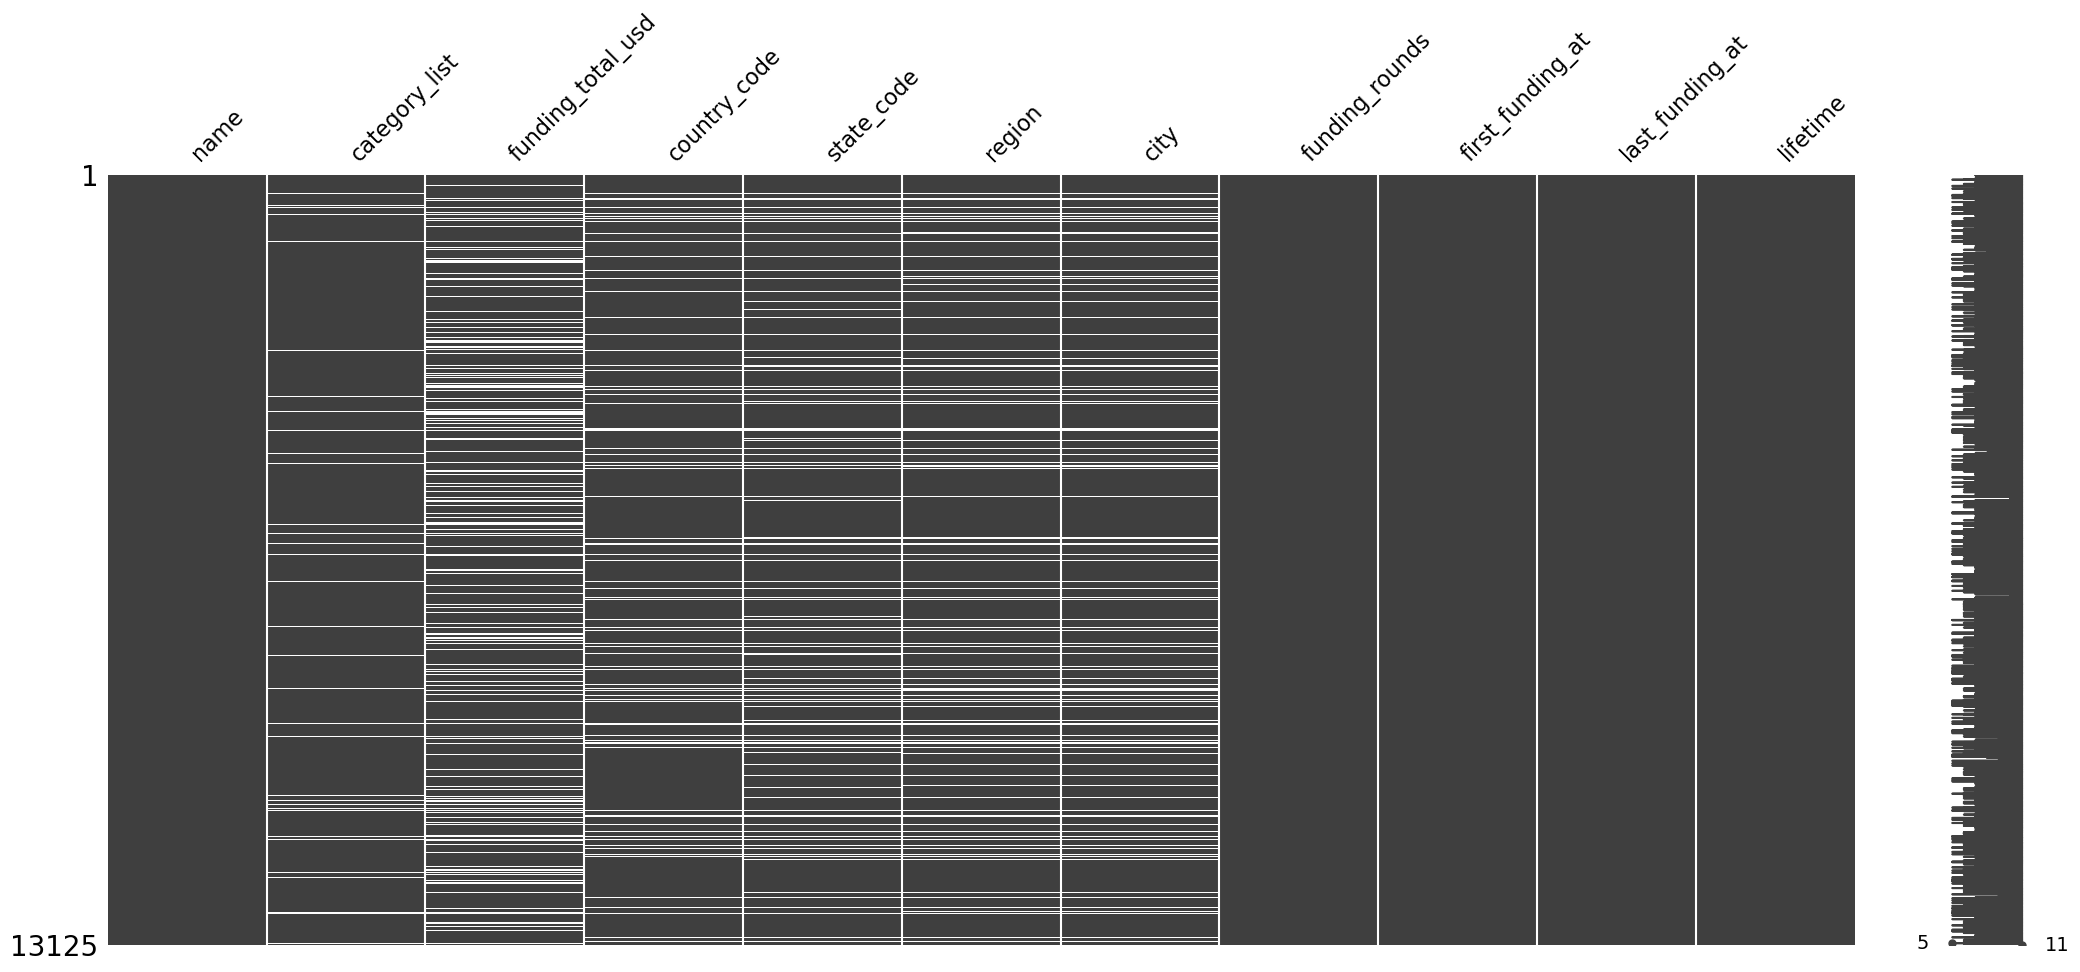

In [174]:
# визуализация пропусков для data_test
msno.matrix(data_test);

Обращает на себя внимание взаимосвязь данных по локации стартапа. Country, state, region, city (10-13% соответствующих столбцов). При отсутствии более общего "географического" признака, отсутствуют и более мелкие уровни. 

Это существенный объем признаков, его требуется заменить неопределенными значениями, не удаляя.

Отсутствие значения funding_total_usd не значит, что стартап не был профиансирован. В funding_rounds нет пропусков и нет значений 0. Поэтому проведем замену пропусков медианным значением.  

В пропуски для closed_at поставим дату выгрузки датасета - "2018-01-01"

In [42]:
# выполним замену пропусков для data_train
data_train['name'] = data_train['name'].fillna('no_name')
data_train['category_list'] = data_train['category_list'].fillna('no_category')
data_train['country_code'] = data_train['country_code'].fillna('no_country')
data_train['state_code'] = data_train['state_code'].fillna('no_state')
data_train['region'] = data_train['region'].fillna('no_region')
data_train['city'] = data_train['city'].fillna('no_city')
data_train['closed_at'] = data_train['closed_at'].fillna('2018-01-01')

# выполним замену пропусков для data_test
data_test['category_list'] = data_test['category_list'].fillna('no_category')
data_test['country_code'] = data_test['country_code'].fillna('no_country')
data_test['state_code'] = data_test['state_code'].fillna('no_state')
data_test['region'] = data_test['region'].fillna('no_region')
data_test['city'] = data_test['city'].fillna('no_city')

In [43]:
# замена пропусков funding_total_usd для data_train
median_1 = data_train['funding_total_usd'].median()
data_train['funding_total_usd'].fillna(median_1, inplace=True)

C:\Users\pegof\AppData\Local\Temp\ipykernel_10136\3759091697.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['funding_total_usd'].fillna(median_1, inplace=True)


In [44]:
# замена пропусков funding_total_usd для data_test
median_2 = data_test['funding_total_usd'].median()
data_test['funding_total_usd'].fillna(median_2, inplace=True)

C:\Users\pegof\AppData\Local\Temp\ipykernel_10136\2736070368.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_test['funding_total_usd'].fillna(median_2, inplace=True)


In [45]:
data_train.isnull().sum()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

In [46]:
data_test.isnull().sum()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

Пропуски в обоих датасетах заполнены, в соответствии со схемой, приведенной выше.

<div class="alert alert-block alert-info">
Шаг 2.3. Типы данных
</div>

Типы данных выглядят корректными. Единственный случай, требующий корректировки - смена категориального типа на "datatime" для "closed_at".

In [50]:
# исправим тип данных "closed_at"
data_train['closed_at'] = pd.to_datetime(data_train['closed_at'], format='%Y-%m-%d')

In [51]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  object        
 10  first_funding_at   52516 non-null  object        
 11  last_funding_at    52516 non-null  object        
 12  closed_at          52516 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(10)
memory

Тип данных отработан

<div class="alert alert-block alert-info">
Шаг 2.4. Дубликаты
</div>

In [54]:
# оценим % дубликатов для тренировочной выборки
data_train.set_index('name', inplace = True)
print(f'Дубликаты в data_train', data_train.duplicated().sum())
print(f'Процент от общего числа:', round((data_train.duplicated().sum() / data_train_shape), 4) * 100, f'%')

Дубликаты в data_train 10
Процент от общего числа: 0.02 %


In [154]:
# удалим найденные дубликаты
data_train = data_train.drop_duplicates()
data_train = data_train.reset_index()

In [56]:
# оценим % дубликатов для тестовой выборки
data_test.set_index('name', inplace = True)
print(f'Дубликаты в data_test', data_test.duplicated().sum())
print(f'Процент от общего числа:', round((data_test.duplicated().sum() / data_test_shape), 4) * 100, f'%')

Дубликаты в data_test 1
Процент от общего числа: 0.01 %


Количество дубликатов некритично, оставим их без изменений.

Дубликаты отработаны

<div class="alert alert-block alert-info">
Шаг 2.5. Добавление новых столбцов
</div>

Оценим количество уникальных значений в тренировочном и тестовом датасетах.

In [61]:
data_train.nunique()

name                 52506
category_list        22106
funding_total_usd    15551
status                   2
country_code           135
state_code             301
region                1037
city                  4478
funding_rounds          19
founded_at            5402
first_funding_at      4603
last_funding_at       4305
closed_at             3009
dtype: int64

In [156]:
data_test.nunique()

category_list        6207
funding_total_usd    4549
country_code           97
state_code            236
region                689
city                 2118
funding_rounds         15
first_funding_at     3299
last_funding_at      3021
lifetime             3456
geo_region             23
dtype: int64

Географические признаки компании-стартапа (4 уровня, от национального до уровня населенного пункта) окажут существенное влияние на обучеение нашей модели. При этом, количество уникальных значений в столбце country_code относительно невелико - 135 для "df_train". Введем новый укрупненный географический признак, объединяющий страны в суб-регионы.  
  
Для этого используем ISO-3_код страны и данные с сайта 'https://cloford.com/resources/codes/index.htm'. Используем критерий региона, т.к. признак континента дает излишнее для целей исследования укрупнение.

In [64]:
# создаем функцию для определния географического суб-региона страны по её ISO-3_коду
def find_geo_region(ctry_iso):

    '''
    Функция принимает ISO-3_код страны и привязывает страну
    к конкретному географическому суб-региону
    '''
    
    # создаем словарь с географическими суб-регионами и странами
    countries_dict = {
        'Central Africa' : ['RWA'],
        'Central America' : ['BLZ', 'CRI', 'GTM', 'HND', 'MEX', 'NIC', 'PAN', 'SLV'],
        'Central Asia' : ['KAZ', 'UZB'],
        'Central Europe' : ['AUT', 'CHE', 'CZE', 'HUN', 'LIE', 'SVK'],
        'East Asia' : ['CHN', 'HKG', 'JPN', 'KOR', 'TWN'],
        'Eastern Africa' : ['KEN', 'SOM', 'TAN', 'UGA'],
        'Eastern Europe' : ['BLR', 'EST', 'LTU', 'LVA', 'MDA', 'POL', 'UKR'],
        'Indian Ocean' : ['MUS', 'SYC'],
        'no_region' : ['no_country'],
        'North America' : ['CAN', 'USA'],
        'Northern Africa' : ['DZA', 'EGY', 'MAR', 'TUN'],
        'Northern Asia' : ['RUS'],
        'Northern Europe' : ['DNK', 'FIN', 'ISL', 'NOR', 'SWE'],
        'Pacific' : ['AUS', 'NZL'],
        'South America' : ['ARG', 'BRA', 'CHL', 'COL', 'ECU', 'PER', 'PRY', 'URY', 'VEN'],
        'South Asia' : ['BGD', 'IND', 'LKA', 'NPL', 'PAK'],
        'South East Asia' : ['BRN', 'IDN', 'KHM', 'LAO', 'MMR', 'MYS', 'PHL', 'SGP', 'THA', 'VNM'],
        'South East Europe' : ['ALB', 'BGR', 'GRC', 'HRV', 'MKD', 'MNE', 'ROM', 'SRB', 'SVN'],
        'South West Asia' : ['ARE', 'ARM', 'AZE', 'BHR', 'CYP', 'GEO', 'IRN', 'ISR', 'JOR', 'KWT', 'LBN', 'OMN', 'PSE', 'QAT', 'SAU', 'TUR'],
        'South West Europe' : ['ESP', 'GIB', 'PRT'],
        'Southern Africa' : ['BWA', 'MOZ', 'ZAF', 'ZMB', 'ZWE'],
        'Southern Europe' : ['ITA', 'MLT'],
        'West Indies' : ['BAH', 'BLM', 'BMU', 'CYM', 'DOM', 'GRD', 'JAM', 'KNA', 'MAF', 'PRI', 'TTO'],
        'Western Africa' : ['CMR', 'GHA', 'NGA', 'SEN', 'TGO'],
        'Western Europe' : ['BEL', 'DEU', 'FRA', 'GBR', 'GGY', 'IRL', 'JEY', 'LUX', 'MCO', 'NLD']
    }

    # с помощью цикла находим вхождение наименования страны в соотвествующий регион
    for k in countries_dict.keys():
        if ctry_iso in countries_dict[k]:
            return k

In [180]:
# применим функцию и добавим новый столбец
data_train.loc[:, 'geo_region'] = data_train.loc[:, 'country_code'].apply(find_geo_region)
data_test.loc[:, 'geo_region'] = data_test.loc[:, 'country_code'].apply(find_geo_region)

In [245]:
# проверка привязки к суб-региону
print(f'Результат добавления колонки "geo_sub_region" в датафрейм "data_train":')
display(data_train[['name', 'country_code', 'geo_region']].sample(5))
print(f'Результат добавления колонки "geo_sub_region" в датафрейм "data_test":')
display(data_test[['name', 'country_code', 'geo_region']].sample(5))

Результат добавления колонки "geo_sub_region" в датафрейм "data_train":


KeyError: "['geo_region'] not in index"

Новый признак для удобства исследования успешно добавлен.

<div class="alert alert-block alert-info">
Шаг 3. Исследовательский анализ данных
</div>

Оценим распределение количественных данных в сете data_train

In [247]:
data_train.describe()

,funding_total_usd,funding_rounds
count,"42,447.00","52,516.00"
mean,"18,247,480.66",1.74
std,"187,117,301.32",1.37
min,1.00,1.00
25%,"336,027.50",1.00
50%,"2,000,000.00",1.00
75%,"10,000,000.00",2.00
max,"30,079,503,000.00",19.00


In [73]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52506 entries, 0 to 52505
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52506 non-null  object        
 1   category_list      52506 non-null  object        
 2   funding_total_usd  52506 non-null  float64       
 3   status             52506 non-null  object        
 4   country_code       52506 non-null  object        
 5   state_code         52506 non-null  object        
 6   region             52506 non-null  object        
 7   city               52506 non-null  object        
 8   funding_rounds     52506 non-null  int64         
 9   founded_at         52506 non-null  object        
 10  first_funding_at   52506 non-null  object        
 11  last_funding_at    52506 non-null  object        
 12  closed_at          52506 non-null  datetime64[ns]
 13  geo_region         52506 non-null  object        
dtypes: dat

In [ ]:
# создаем списки категориальных и количественных показателей
data_train_num_col = list(data_train.select_dtypes(['int64', 'float64']).columns)
data_train_cat_col = list(data_train.select_dtypes(['object']).columns)

- Гистограммы числовых столбцов

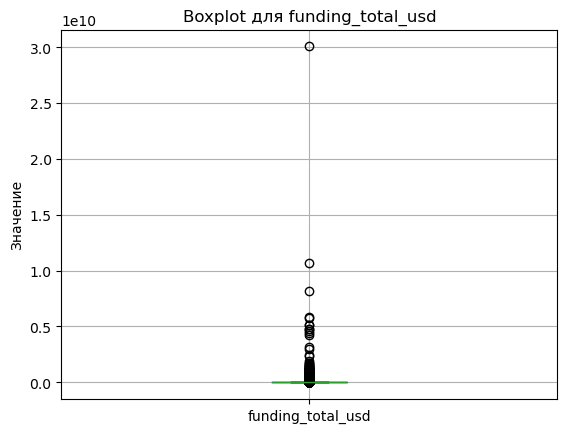

In [249]:
plt.title(f'Boxplot для funding_total_usd')
data_train.boxplot(column=['funding_total_usd'])
plt.ylabel('Значение')
plt.show();

Как видно, 100 млн долларов выступает как граница выбросов.
Присмотримся внимательнее к основной части данных.

In [ ]:
data_train['funding_total_usd'].hist(range=(0,100000000),bins=100)
plt.title(f'hist для funding_total_usd')
plt.xlabel('Сумма')
plt.ylabel('Количество')
plt.show();

In [ ]:
# исключим выбросы в funding_total_usd
data_train = data_train.query('funding_total_usd < 100000000')

In [251]:
data_train.shape

(52516, 13)

Как видим, количественно датасет сократился на 1320 строк или на 2,5%, что не критично для дальнейшего анализа. При этом, ожидаем более высокую точночть предсказаний для нашей будущей модели.

In [182]:
data_test['lifetime'].describe()

count   13,125.00
mean     3,097.61
std      2,128.36
min         52.00
25%      1,726.00
50%      2,526.00
75%      3,866.00
max     17,167.00
Name: lifetime, dtype: float64

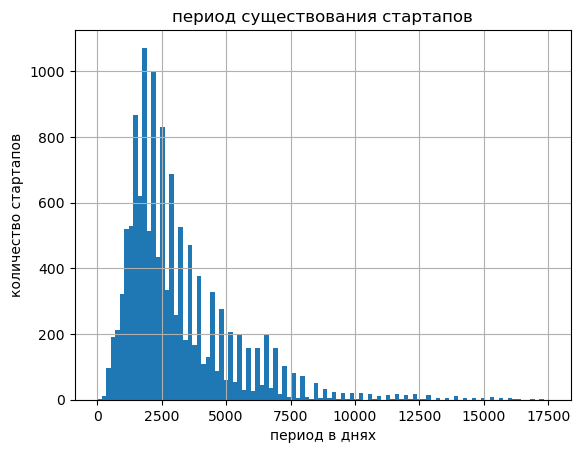

In [253]:
data_test['lifetime'].hist(range=(0,17500),bins=100)
plt.title(f'период существования стартапов')
plt.xlabel('период в днях')
plt.ylabel('количество стартапов')
plt.show();

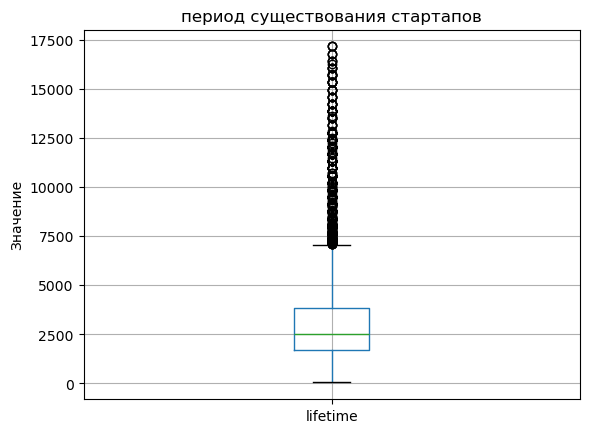

In [75]:
plt.title(f'период существования стартапов')
data_test.boxplot(column=['lifetime'])
plt.ylabel('Значение')
plt.show();

In [ ]:
ax = data_train['status'].value_counts().plot.bar()
plt.title('количество действующих/закрывшихся стартапов')
plt.ylabel('количество')
plt.show()

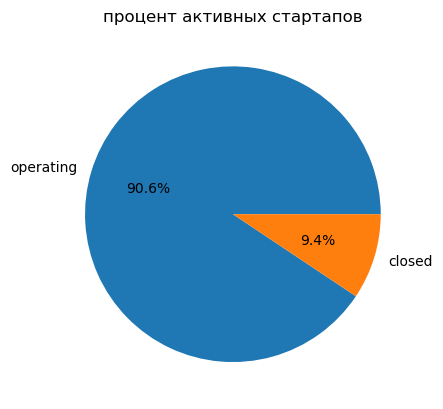

In [141]:
data_train['status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('процент активных стартапов')
plt.ylabel('')
plt.show();

In [ ]:
ax = data_train['geo_region'].value_counts().plot.bar()
plt.title('распределение стартапов по гео-регионам')
plt.ylabel('количество')
plt.show()

In [ ]:
data_train['geo_region'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('процентное соотношение стартапов для гео-региона')
plt.ylabel('')
plt.show();

C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable category_list is very large: 573. Are you sure this is not an interval variable? Analysis for pairs of variables including category_list might be slow.
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable city is very large: 381. Are you sure this is not an interval variable? Analysis for pairs of variables including city might be slow.
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable closed_at is very large: 104. Are you sure this is not an interval variable? Analysis for pairs of variables including closed_at might be slow.
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable region is very large: 225. Are you 

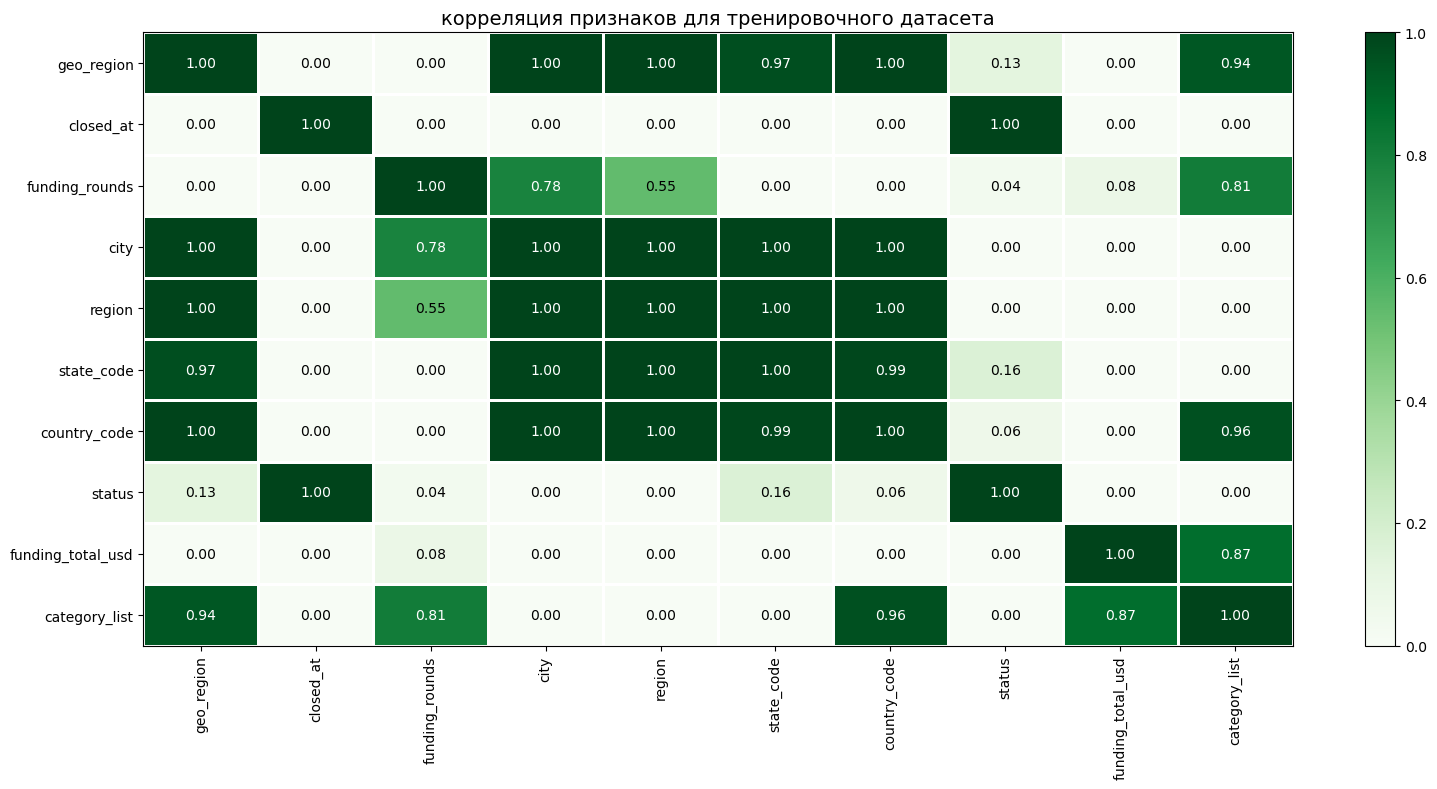

In [139]:
interval_cols = ['funding_total_usd']
corr_matrix = (data_train.drop(['founded_at',
                           'first_funding_at',
                           'last_funding_at',
                           'name'], axis=1)).sample(1000).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(corr_matrix.values, 
                        x_labels=corr_matrix.columns, 
                        y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"корреляция признаков для тренировочного датасета", 
                        fontsize_factor=1, 
                        figsize=(16, 8));
plt.tight_layout();

C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable category_list is very large: 593. Are you sure this is not an interval variable? Analysis for pairs of variables including category_list might be slow.
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable city is very large: 408. Are you sure this is not an interval variable? Analysis for pairs of variables including city might be slow.
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable name is very large: 1000. Are you sure this is not an interval variable? Analysis for pairs of variables including name might be slow.
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\phik\data_quality.py:55: UserWarning: The number of unique values of variable region is very large: 234. Are you sure this

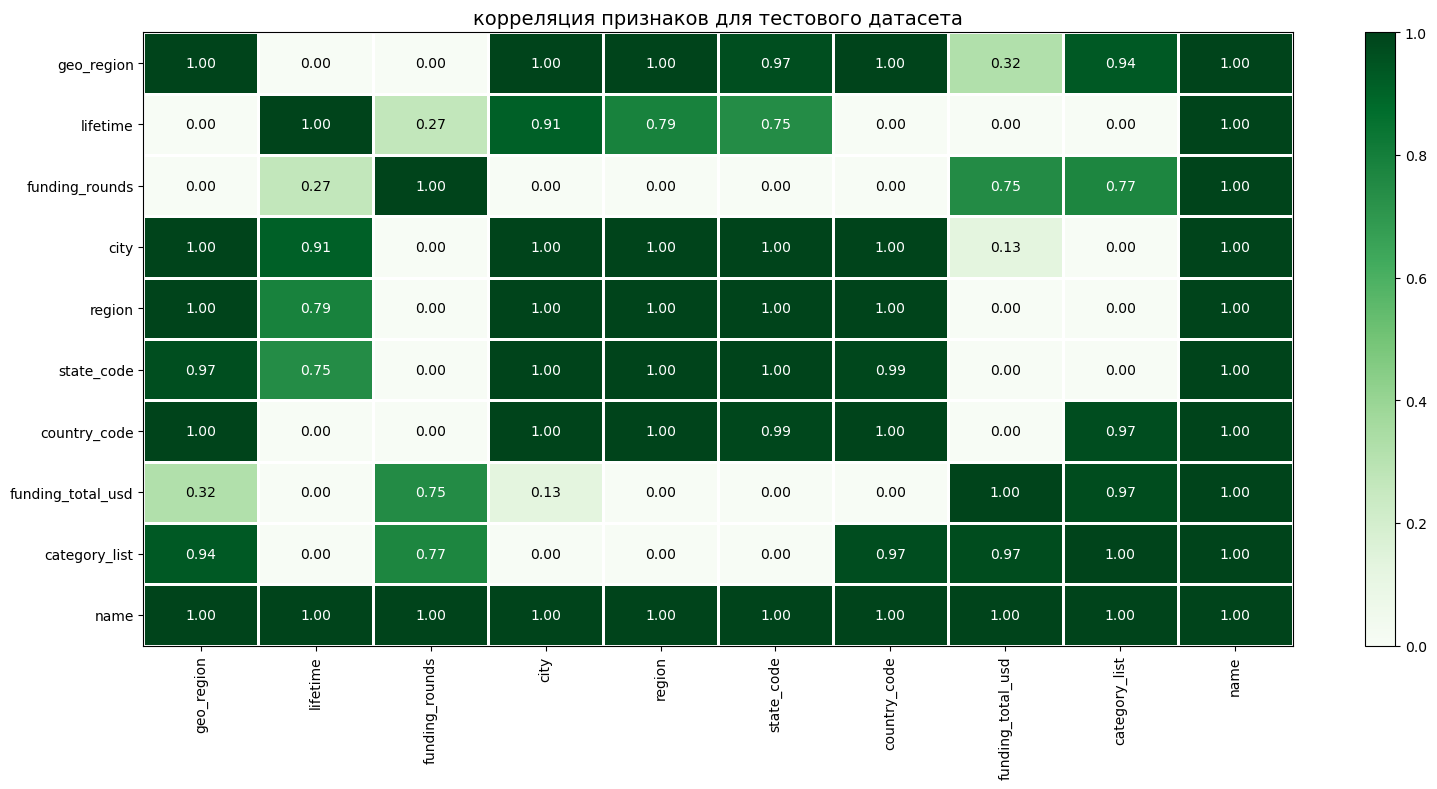

In [184]:
interval_cols = ['lifetime','funding_total_usd']
corr_matrix = (data_test.drop(['first_funding_at',
                           'last_funding_at'], axis=1)).sample(1000).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(corr_matrix.values, 
                        x_labels=corr_matrix.columns, 
                        y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"корреляция признаков для тестового датасета", 
                        fontsize_factor=1, 
                        figsize=(16, 8));
plt.tight_layout();

Вывод  
Распределение признаков   

У таргета присутствует диссбаланс (91% - operating, 9% - closed).
Порядка 70% стартапов находяться в Северной Америки, 17% - в Европе, 10% - в Азии.
Больше всего стартапов в США, Англии и Канаде. Россия за пределами топ-10 в этот период. Что касается городов, то 10 лидеров:
San Francisco: 2824
New York: 2486
London: 1514
Austin: 609
Palo Alto: 605
Los Angeles: 604
Seattle: 592
Chicago: 546
Cambridge: 542
Boston: 508

Количество стартапов начало значительно увеличиваться с 2000 года, причем видно существенное снижение с 2013 по 2015 года. Если разделять по статусам, то заметно, что число закрытых стартапов также начало увеличиваться с 2000 года, заметен небольшой пик с  2006 года и с 2014 го.
Более массированные инвестиции пошли с 2008 года, причем отметим спад с 2014 по 2015 года.

В среднем, сумма инвенстирования сотсавляет 7,5 млн, а медианное значение в районе 2 млн.
В среднем стартапы существуют 2557 дней.
33478 стартапов имели 1 раунд финансирования (это около 64% от общего числа раудов, всего 19)
Больше всего категорий стартапов Biotechnology и Software.

Корреляционный анализ 

Отметим заметную связь географических признаков, связь целевого признака с локацией и количеством раундов, а также связь объема финанирования со специализацияей стартапа.  

<div class="alert alert-block alert-info">
Шаг 4. Подготовка данных
</div>

Подготовим данные для поиска лучшей модели. Создадим пайплайн с использованием ColumnTransformer. Количественные и категориальные данные будут проведены через пайплайн отдельно.

In [78]:
TEST_SIZE = 0.25

#делим датасет data_train на входные и целевой признаки
X = data_train.drop([
    'name', 
    'category_list', 
    'funding_total_usd', 
    'status', 
    'country_code',
    'state_code', 
    'region', 
    'city', 
    'funding_rounds', 
    'founded_at',
    'first_funding_at', 
    'last_funding_at', 
    'closed_at', 
    'geo_region',        
], axis=1).copy()
y = data_train['status'].copy()

# тренировочная и валидационная выборка
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

# выведем на экран размер получившихся данных после подготовки
print('Размер подготовленных выборок:')
display(pd.DataFrame(
    data={
        'Входные признаки(X)': [X_train.shape, X_valid.shape],
        'Целевой признак(y)': [y_train.shape, y_valid.shape]
    }, 
    index=['Тренировочные данные', 'Тестовые данные']
))
print()

# списки признаков
cat_columns = X.select_dtypes(exclude='number').columns.tolist()
num_columns = X.select_dtypes(include='number').columns.tolist()

# экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

# коды категорий целевого признака
print('Результат кодирования целевого признака:')
display(pd.DataFrame(data=label_encoder.classes_, columns=['quit']))

# пайплайны для подготовки признаков
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('sImputer_nan_mf', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('sImputer_sp_mf', SimpleImputer(missing_values = ' ', strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# SimpleImputer + Scaler
num_pipe = Pipeline(
    [
        ('sImputer_nan_med', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# общий пайплайн подтоговки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', ohe_pipe, cat_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
)

Размер подготовленных выборок:


,Входные признаки(X),Целевой признак(y)
Тренировочные данные,"(39379, 3)","(39379,)"
Тестовые данные,"(13127, 3)","(13127,)"



Результат кодирования целевого признака:


,quit
0,closed
1,operating


In [81]:
# применим pipeline для подготовки данных
X_train_pr = data_preprocessor.fit_transform(X_train)
X_valid_pr = data_preprocessor.transform(X_valid)

# список признаков после процесса кодирования
names_ohe = data_preprocessor.transformers_[0][1]['ohe'].get_feature_names_out(cat_columns)
columns_full = names_ohe.tolist() + num_columns

# датафреймы подготовленных данных с входными признаками
X_train_pr = pd.DataFrame(X_train_pr, columns=columns_full)
X_valid_pr = pd.DataFrame(X_valid_pr, columns=columns_full)

# проверка
display(X_train_pr.sample(5))
display(X_valid_pr.sample(5))

,geo_region_Central America,geo_region_Central Asia,geo_region_Central Europe,geo_region_East Asia,geo_region_Eastern Africa,geo_region_Eastern Europe,geo_region_Indian Ocean,geo_region_North America,geo_region_Northern Africa,geo_region_Northern Asia,...,geo_region_South West Asia,geo_region_South West Europe,geo_region_Southern Africa,geo_region_Southern Europe,geo_region_West Indies,geo_region_Western Africa,geo_region_Western Europe,geo_region_no_region,funding_total_usd,funding_rounds
25686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.072393,-0.539454
3858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.082238,-0.539454
34525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276010,0.917503
23008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.081383,0.189024
14058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.072393,-0.539454


,geo_region_Central America,geo_region_Central Asia,geo_region_Central Europe,geo_region_East Asia,geo_region_Eastern Africa,geo_region_Eastern Europe,geo_region_Indian Ocean,geo_region_North America,geo_region_Northern Africa,geo_region_Northern Asia,...,geo_region_South West Asia,geo_region_South West Europe,geo_region_Southern Africa,geo_region_Southern Europe,geo_region_West Indies,geo_region_Western Africa,geo_region_Western Europe,geo_region_no_region,funding_total_usd,funding_rounds
8563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.076769,-0.539454
9662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076113,0.189024
11296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.068012,-0.539454
10092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.072393,-0.539454
5796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.072393,-0.539454


<div class="alert alert-block alert-info">
Шаг 5. Выбор и обучение модели
</div>

Обучим и выведем метрику F1-score на моделях: Логистическая регрессия, kNN, Дерево решений.
Подбор гиперпараметров выполним с помощью OptunaSearchCV.

In [83]:

# при помощи цикла проведем поиск гиперпараметров для всех моделей
RANDOM_STATE = 42


# применим pipeline для подготовки данных
X_train_pr = data_preprocessor.fit_transform(X_train)
X_valid_pr = data_preprocessor.transform(X_valid)

# список признаков после процесса кодирования
names_ohe = data_preprocessor.transformers_[0][1]['ohe'].get_feature_names_out(cat_columns)
columns_full = names_ohe.tolist() + num_columns

# датафреймы подготовленных данных с входными признаками
X_train_pr = pd.DataFrame(X_train_pr, columns=columns_full)
X_valid_pr = pd.DataFrame(X_valid_pr, columns=columns_full)



for m in ['log', 'knn', 'dtr']:
    
    if m == 'log':
        # имя модели
        model_name = 'LogisticRegression'
        # инициализация
        model = LogisticRegression(
            class_weight='balanced', 
            random_state=RANDOM_STATE
        )
        # список гиперпараметров
        parameters = {
            'penalty' : distributions.CategoricalDistribution(choices=('l1', 'l2')),
            'C': distributions.CategoricalDistribution(choices=(0.01, 0.1, 1, 10, 100, 1000)),
            'solver' : distributions.CategoricalDistribution(choices=('lbfgs', 'saga')),
            'max_iter' : distributions.CategoricalDistribution(choices=(100, 1000, 2000))
        }

    elif m == 'knn':
        model_name = 'kNN'
        model = KNeighborsClassifier()
        parameters = {
            'n_neighbors': distributions.IntDistribution(2, 40, log=False, step=1)
        } 

    elif m == 'dtr':
        model_name = 'DecisionTree'
        model = DecisionTreeClassifier(
            class_weight='balanced', 
            random_state=RANDOM_STATE
        )
        parameters = {
            'max_depth': distributions.IntDistribution(2, 50),
            'min_samples_split': distributions.IntDistribution(2, 50),
            'min_samples_leaf': distributions.IntDistribution(2, 50)
        } 
        
    
    # инициализация OptunaSearchCV
    oscv = OptunaSearchCV(
        model,
        parameters,
        scoring='f1',
        cv=5,
        n_trials=10,
        random_state=RANDOM_STATE,
        refit=True
    )
    
    # проведем поиск гиперпараметров
    oscv.fit(X_train_pr, y_train)

    # название модели
    print(f'Подбор гиперпараметров для модели {model_name}:')
    
    # лучшие гиперпараметры
    print(f'- лучшие гиперпараметры: {oscv.best_params_}')
    
    # F1 на кросс-валидации
    print(f'- метрика F1-score на кросс-валидации: {oscv.best_score_:.5f}')

    # сохраним результаты подбора в переменные
    globals()['oscv_' + m + '_best_params'] = oscv.best_params_
    globals()['oscv_' + m + '_best_score'] = oscv.best_score_

C:\Users\pegof\AppData\Local\Temp\ipykernel_10136\2004013257.py:58: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(
[I 2024-08-11 14:39:10,660] A new study created in memory with name: no-name-7f26ee74-154e-4c35-83a3-78fd3fe030a8
C:\Users\pegof\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pegof\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coe

Подбор гиперпараметров для модели LogisticRegression:
- лучшие гиперпараметры: {'penalty': 'l2', 'C': 1, 'solver': 'saga', 'max_iter': 100}
- метрика F1-score на кросс-валидации: 0.90745


[I 2024-08-11 14:40:59,510] Trial 0 finished with value: 0.9503567860330163 and parameters: {'n_neighbors': 19}. Best is trial 0 with value: 0.9503567860330163.
[I 2024-08-11 14:41:02,535] Trial 1 finished with value: 0.9506259871281755 and parameters: {'n_neighbors': 34}. Best is trial 1 with value: 0.9506259871281755.
[I 2024-08-11 14:41:05,501] Trial 2 finished with value: 0.9324914813659971 and parameters: {'n_neighbors': 4}. Best is trial 1 with value: 0.9506259871281755.
[I 2024-08-11 14:41:08,358] Trial 3 finished with value: 0.9496142500630057 and parameters: {'n_neighbors': 14}. Best is trial 1 with value: 0.9506259871281755.
[I 2024-08-11 14:41:11,209] Trial 4 finished with value: 0.9501692768552349 and parameters: {'n_neighbors': 20}. Best is trial 1 with value: 0.9506259871281755.
[I 2024-08-11 14:41:14,247] Trial 5 finished with value: 0.9498963375698188 and parameters: {'n_neighbors': 13}. Best is trial 1 with value: 0.9506259871281755.
[I 2024-08-11 14:41:17,067] Trial 6

Подбор гиперпараметров для модели kNN:
- лучшие гиперпараметры: {'n_neighbors': 34}
- метрика F1-score на кросс-валидации: 0.95063


[I 2024-08-11 14:41:26,056] Trial 0 finished with value: 0.7656528529496919 and parameters: {'max_depth': 24, 'min_samples_split': 42, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7656528529496919.
[I 2024-08-11 14:41:26,414] Trial 1 finished with value: 0.7782929735935118 and parameters: {'max_depth': 17, 'min_samples_split': 25, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.7782929735935118.
[I 2024-08-11 14:41:26,726] Trial 2 finished with value: 0.8264761900491007 and parameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8264761900491007.
[I 2024-08-11 14:41:27,061] Trial 3 finished with value: 0.7773980005550907 and parameters: {'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 50}. Best is trial 2 with value: 0.8264761900491007.
[I 2024-08-11 14:41:27,458] Trial 4 finished with value: 0.7569821246326847 and parameters: {'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 21}. Best is t

Подбор гиперпараметров для модели DecisionTree:
- лучшие гиперпараметры: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 10}
- метрика F1-score на кросс-валидации: 0.82648


In [84]:
# результаты обучения 
print('Результаты работы моделей:')
display(pd.DataFrame(
    data={
        'Лучшие гиперпараметры': [
            oscv_log_best_params, 
            oscv_knn_best_params, 
            oscv_dtr_best_params
        ],
        'Лучшая метрика F1': [
            oscv_log_best_score,
            oscv_knn_best_score,
            oscv_dtr_best_score
        ]
    }, 
    index=[
        'Logistic regression',
        'kNN',
        'DecisionTree'
    ]
))

Результаты работы моделей:


,Лучшие гиперпараметры,Лучшая метрика F1
Logistic regression,"{'penalty': 'l2', 'C': 1, 'solver': 'saga', 'm...",0.907445
kNN,{'n_neighbors': 34},0.950626
DecisionTree,"{'max_depth': 12, 'min_samples_split': 10, 'mi...",0.826476


In [97]:
# инициализируем DummyClassifier
dummy_clf = DummyClassifier(random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

dummy_pred = dummy_clf.predict(X_valid)
dummy_f1 = f1_score(y_valid, dummy_pred)

# F1 на тестовых данных
print(f'Метрика F1 на тестовой выборке в DummyClassifier: {dummy_f1:.3f}')

Метрика F1 на тестовой выборке в DummyClassifier: 0.952


In [266]:
# используем pipeline для подготовки данных
X_train_pr = data_preprocessor.fit_transform(X_train)
X_valid_pr = data_preprocessor.transform(X_valid)

# создадим список признаков после процесса кодирования
names_ohe = data_preprocessor.transformers_[0][1]['ohe'].get_feature_names_out(cat_columns)
columns_full = names_ohe.tolist() + num_columns

# датафреймы подготовленных данных с входными признаками
X_train_pr = pd.DataFrame(X_train_pr, columns=columns_full)
X_valid_pr = pd.DataFrame(X_valid_pr, columns=columns_full)

# размер получившихся данных после подготовки
print('Размер подготовленных данных:')
display(pd.DataFrame(
    data={
        'Входные признаки(X)': [X_train_pr.shape, X_valid_pr.shape],
        'Целевой признак(y)': [y_train.shape, y_valid.shape]
    }, 
    index=['Тренировочные данные', 'Тестовые данные']
))
print()

# инициализируем лучшую модель
model_log = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# списки для внесения в них данных
k_qty=[]
score_train_mean=[]
score_train_std=[]
score_valid=[]

# проведем поиск лучшего набора признаков 
for i in range(len(X_train_pr.columns)):
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_pr, y_train)
    
    features_names = X_train_pr.columns[selector.get_support(indices=True)]
    
    X_train_sel = X_train_pr[list(features_names)]
    X_valid_sel = X_valid_pr[list(features_names)]
    
    result_train = cross_val_score(model_log, X_train_sel, y_train, cv=5, scoring='f1')
    
    model_log.fit(X_train_sel, y_train)
    y_pred = model_log.predict(X_valid_sel)
    result_valid = f1_score(y_valid, y_pred)
    
    k_qty.append(i+1)
    score_train_mean.append(result_train.mean())
    score_train_std.append(result_train.std())
    score_valid.append(result_valid)

# сохраним результаты анализа
SelectKBest_overview = pd.DataFrame(
                                    data={
                                        'количество_признаков': k_qty,
                                        'среднее_F1_train_CV': score_train_mean,
                                        'ст_отклонение_train_CV': score_train_std,
                                        'F1_valid': score_valid
                                    })

# результаты
print('Анализ лучших метрик с разным количеством признаков:')
pd.options.display.float_format ='{:,.5f}'.format
display(SelectKBest_overview)
print()

# сортируем результаты
print('Пять лучших результатов метрики с сортировкой:')
display(SelectKBest_overview
        .sort_values(
            by=['F1_valid', 'среднее_F1_train_CV', 'количество_признаков'],
            ascending=[False, False, True])
        .head(5)
)
pd.options.display.float_format ='{:,.2f}'.format

Размер подготовленных данных:


,Входные признаки(X),Целевой признак(y)
Тренировочные данные,"(39379, 26)","(39379,)"
Тестовые данные,"(13127, 26)","(13127,)"



Анализ лучших метрик с разным количеством признаков:


,количество_признаков,среднее_F1_train_CV,ст_отклонение_train_CV,F1_valid
0,1,0.91650,0.00140,0.91896
1,2,0.91516,0.00141,0.91706
2,3,0.91531,0.00147,0.91715
3,4,0.91531,0.00147,0.91715
4,5,0.91531,0.00147,0.91715
5,6,0.91531,0.00147,0.91715
6,7,0.91531,0.00147,0.91715
7,8,0.91531,0.00147,0.91715
8,9,0.91531,0.00147,0.91715
9,10,0.91531,0.00147,0.91715



Пять лучших результатов метрики с сортировкой:


,количество_признаков,среднее_F1_train_CV,ст_отклонение_train_CV,F1_valid
0,1,0.91650,0.00140,0.91896
10,11,0.91531,0.00147,0.91720
11,12,0.91531,0.00147,0.91720
13,14,0.91077,0.01016,0.91720
12,13,0.91065,0.01038,0.91720


In [268]:
# количество признаков для получения лучшей метрики
k_best = 12

# селектор с нужными параметрами
selector = SelectKBest(f_classif, k=k_best)

# обучение
selector.fit(X_train_pr, y_train)

# список с лучшими признаками
features_names = X_train_pr.columns[selector.get_support(indices=True)]

# новый набор данных
X_train_sel = X_train_pr[list(features_names)]
X_valid_sel = X_valid_pr[list(features_names)]

# список лучших признаков
print('Список лучших признаков:')
display(features_names.tolist())
print()

# список наименее важных признаков
print('Список наименее важных признаков:')
print(list(set(X_train_pr.columns) - set(features_names)))
print()

Список лучших признаков:


['geo_region_East Asia',
 'geo_region_North America',
 'geo_region_Northern Asia',
 'geo_region_South Asia',
 'geo_region_South East Asia',
 'geo_region_South West Asia',
 'geo_region_South West Europe',
 'geo_region_Southern Europe',
 'geo_region_Western Europe',
 'geo_region_no_region',
 'funding_total_usd',
 'funding_rounds']


Список наименее важных признаков:
['geo_region_Indian Ocean', 'geo_region_Pacific', 'geo_region_Western Africa', 'geo_region_Central America', 'geo_region_Central Asia', 'geo_region_West Indies', 'geo_region_Northern Europe', 'geo_region_Central Europe', 'geo_region_South America', 'geo_region_Northern Africa', 'geo_region_Eastern Africa', 'geo_region_Eastern Europe', 'geo_region_South East Europe', 'geo_region_Southern Africa']



In [113]:
# обучаю модель
model_log.fit(X_train_sel, y_train)

# получаем оценки вероятностей для класса
y_proba = model_log.predict_proba(X_valid_sel)

# создаю список пробных порогов классификации
thresholds = [round(i,2) for i in np.linspace(0.1, 1, num = 50, endpoint=False)]

# создаю пустые списки для сохранение промежуточных значений метрик
col_threshold=[]
col_f1_score=[]

# циклом рассчитываю метрики при разных значениях порога
for i in thresholds:
    # определяю принадлежность классам на основе порога
    proba = (y_proba[:, 1] >= i).astype(int)

    # вношу значения метрик в списки
    col_threshold.append(i)
    col_f1_score.append(round(f1_score(y_valid, proba), 5))

    # завершаю работу цикла, если f1 стала равна 100%
    if f1_score(y_valid, proba) == 1:
        break

pd.options.display.float_format ='{:,.5f}'.format

# помещаю результаты в датафрейм и вывожу результаты на экран
result = pd.DataFrame({'Threshold' : col_threshold, 
                      'F1-score' : col_f1_score
                     })

# вывожу 5 лучших результатов на экран с сортировкой по убыванию
display(result
        .sort_values(by='F1-score', ascending=False)
        .head(5)
)

pd.options.display.float_format ='{:,.2f}'.format

,Threshold,F1-score
0,0.10000,0.95152
1,0.12000,0.95152
2,0.14000,0.95152
3,0.15000,0.95058
4,0.17000,0.95006


# Итоговая оценка качества предсказания лучшей модели #

Метрика F1 для лучшей модели c лучшими признаками
- метрика F1 на валидационной выборке: 91.996%

Матрица ошибок:


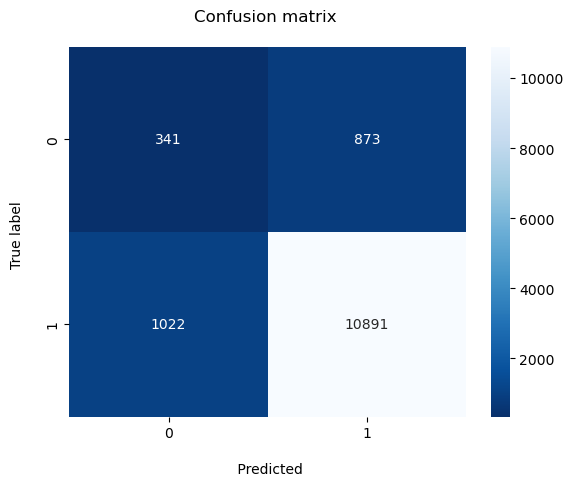

In [218]:
# задаю порог классификации
threshold = 0.33

# определяю принадлежность классам на основе порога
y_pred_adj = (y_proba[:, 1] >= threshold).astype(int)

# считаю метрику F1 на валидационной выборке
result_valid = f1_score(y_valid, y_pred_adj)

# вывожу на экран результаты
print('Метрика F1 для лучшей модели c лучшими признаками')
print(f'- метрика F1 на валидационной выборке: {result_valid * 100:.3f}%')
print()

# подготавливаю матрицу ошибок и вывожу её на экран
cm = confusion_matrix(y_valid, y_pred_adj)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r').set_title('Confusion matrix \n')
plt.ylabel('True label \n')
plt.xlabel('\n Predicted')
print('Матрица ошибок:')
plt.show()
print()

In [224]:
# входные и целевой признаки
X_test = data_test.drop([
    #'name', 
    #'category_list', 
    #'funding_total_usd', 
    #'country_code',
    #'state_code', 
    #'region', 
    #'city', 
    #'funding_rounds', 
    #'first_funding_at', 
    #'last_funding_at', 
    #'lifetime',
    #'geo_region',
    ], axis=1).copy()
y = data_train['status'].copy()

# применим pipeline для подготовки данных
X_test_pr = data_preprocessor.transform(X_test)

# список признаков после процесса кодирования
names_ohe = data_preprocessor.transformers_[0][1]['ohe'].get_feature_names_out(cat_columns)
columns_full = names_ohe.tolist() + num_columns

# датафреймы подготовленных данных с входными признаками
X_test_pr = pd.DataFrame(X_test_pr, columns=columns_full)

# новый набор данных c лучшими колонками
X_test_sel = X_test_pr[list(features_names)]

# предсказания
y_test = model_log.predict(X_test_sel)

# датафрейм с предсказаниями
data_result = pd.DataFrame(
    data={
        'name': data_test['name'],
        'status': ['operating' if x == 1 else 'closed' for x in y_test]
    }
)

# валидизация результата
display(data_result.sample(5))

# доля значений в колонке status
print('Количество объектов каждого статуса в df_test')
display(data_result['status'].value_counts())

# csv файл
#data_result.to_csv('startups_submit_predict_lr.csv', index=False)

C:\Users\pegof\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,name,status
1601,Logentries,operating
5427,HelpCrunch,operating
12378,LittleFoot Energy Finance,operating
3130,Next Points,operating
5543,WorkAmerica,operating


Количество объектов каждого статуса в df_test


status
operating    13038
closed          87
Name: count, dtype: int64

<div class="alert alert-block alert-info">
Шаг 7. Анализ важности признаков
</div>

In [226]:
# инициализируем Explainer(), считаем значения SHAP
explainer = shap.Explainer(model_log.predict_proba, X_valid_sel)
shap_values = explainer(X_valid_sel)

PermutationExplainer explainer: 13128it [04:40, 45.23it/s]                                                             


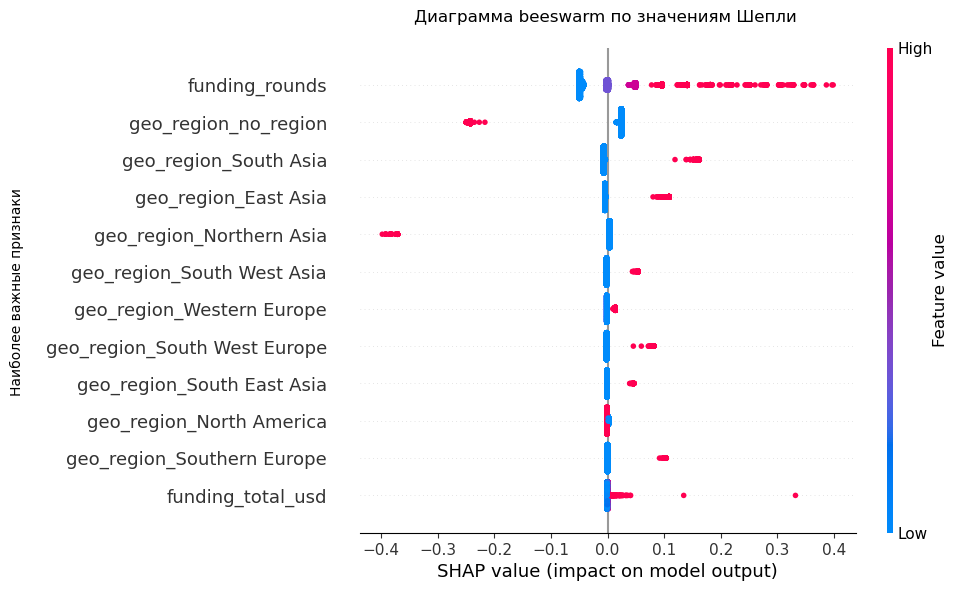

In [228]:
# диаграмма beeswarm
(
    shap.plots
    .beeswarm(shap_values[:,:,1], max_display=k_best, show=False)
    .set_title('Диаграмма beeswarm по значениям Шепли \n')
)

plt.ylabel('Наиболее важные признаки \n')
plt.show()

<div class="alert alert-block alert-info">
Шаг 8. Отчет по результатам исследования
</div>

Требовалось решить следующие задачи:

Разработать модель машинного обучения для предсказания продолжения деятельности стартапа.
Провести разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на итоговый успех).

Датафрейм data_train состоит из 52 514 строк и 13 столбцов, имеет колонки с пропусками.
Датафрейм data_test состоит из 13 125 строк и 12 столбцов, имеет колонки с пропусками.

В тренировочных данных есть колонка 'closed_at' а в тестовых ее нет, но добавлена 'lifetime'.

В процессе предобработки данных:

наименования колонок не требовали преобразования;
обнаружены и заменены все пропуски;
исправлены типы данных;
явных дубликатов, требующих дополнительной обработки не обнаружено.   
добавлены новые колонки: 'geo_region'

Исследовательский анализ

проведён исследовательский анализ признаков 
ключевые признаки рассмотрены в абсолютных и относительных величинах  
проведён корреляционный анализ для тренировочного и тестового датафреймов


Обнаруженные особенности:

Распределение признаков

У таргета присутствует диссбаланс (91% - operating, 9% - closed). Порядка 70% стартапов находяться в Северной Америки, 17% - в Европе, 10% - в Азии. Больше всего стартапов в США, Англии и Канаде. Россия за пределами топ-10 в этот период. Что касается городов, то 10 лидеров: San Francisco: 2824 New York: 2486 London: 1514 Austin: 609 Palo Alto: 605 Los Angeles: 604 Seattle: 592 Chicago: 546 Cambridge: 542 Boston: 508

Количество стартапов начало значительно увеличиваться с 2000 года, причем видно существенное снижение с 2013 по 2015 года. Если разделять по статусам, то заметно, что число закрытых стартапов также начало увеличиваться с 2000 года, заметен небольшой пик с 2006 года и с 2014 го. Более массированные инвестиции пошли с 2008 года, причем отметим спад с 2014 по 2015 года.

В среднем, сумма инвенстирования сотсавляет 7,5 млн, а медианное значение в районе 2 млн. В среднем стартапы существуют 2557 дней. 33478 стартапов имели 1 раунд финансирования (это около 64% от общего числа раудов, всего 19) Больше всего категорий стартапов Biotechnology и Software.

Корреляционный анализ

Отметим заметную связь географических признаков, связь целевого признака с локацией и количеством раундов, а также связь объема финанирования со специализацияей стартапа.

Выполнена подготовка данных для применениях в моделях машинного обучения с помощью пайплайнов. Проведена замена целевого признака с помощью LabelEncoder.

В рамках решения задачи классификации - прогнозирование статуса стартапа, были выбраны и обучены 3 модели: LogisticRegression, kNN, DecisionTreeClassifier. Поиск гиперпараметров вёлся с помощью OptunaSearchCV. Метрика считалась на кросс-валидации. Лучшей модельюkNN регрессия. Для достоверности проведена сравнительная оценка модели с условной baseline моделью DummyCl  тив 0.951.

Выполнен поиск лучших признаков, которые дают максимальное значение мела 99,91%.

Построена матрица ошибок для полученной модели со следующими результатами:

истинно положительные предсказания (стартап работает и модель0891а): 11 613
ложноположительные предсказания (стартап закрылся и модель о873блась): 21
истинно отрицательные предсказания(стартап закрылся и модел341ава): 1165
ложноотрицательные предсказания(стартап работает и модель о1022иббучения.

Проведена интерпретация признаков с помощью значений Шепли:

самыми значимыми признакамиifetime rounds и funding_total_usdederating');
также заметное влияние на результат предсказания модели оказываю е 3 и geo__no_region. С их положительным значением растёт шанс предсказания закрытия   признаки.

Выполненная работа над проектом позволяет составить некоторые рекомосновная часть стартапово датасета находятся в странах североамериканского и западноевропейско, чтогиона. Что адаптированной для новых компаний инфратруктурес сфера высокотехнологичных производств и услугю(т в сфере биитеitприложений,ая торговля и ммерции) наиболее интересна как область для вложений; на успех;
медиансуществованиякрывшегося  околостх лет, нужно продержаться дольшетот период.